# PROYECTO MICROCREDITO

In [61]:
!pip install lightgbm
!pip install shap

##Importaciones

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split, ParameterGrid, StratifiedKFold
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, balanced_accuracy_score, classification_report, roc_curve, make_scorer
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import EasyEnsembleClassifier, BalancedRandomForestClassifier
import pickle
from joblib import dump
import os
import matplotlib.ticker as ticker
import shap

## Carga de datos

In [63]:
# Montar drive
drive.mount('/content/drive')

# Desmontar drive inmediatamente
#drive.flush_and_unmount()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
# Cargo los archivos de las particiones como un dataframe
X_train_seleccionado = pd.read_csv('/content/drive/MyDrive/proyecto_microcreditos/data/processed/X_train_sel3.csv')
y_train = pd.read_csv('/content/drive/MyDrive/proyecto_microcreditos/data/processed/y_train3.csv')
X_test_seleccionado = pd.read_csv('/content/drive/MyDrive/proyecto_microcreditos/data/processed/X_test_sel3.csv')
y_test = pd.read_csv('/content/drive/MyDrive/proyecto_microcreditos/data/processed/y_test3.csv')

In [65]:
# Configurar la opcion para ver todas las columnas
pd.set_option('display.max_columns', None)

In [66]:
# Configurar la opcion para ver 500 filas
pd.set_option('display.max_rows', 500)

## Modelo RandomForestClassifier

In [67]:
# Definición explícita de pesos
class_weights = {0: 1.0, 1: 	56961 / 18588}  # ≈ {0:1.0, 1:3.06}

"""# Entrenar un modelo RFC
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight=class_weights,  # Pesos personalizados para el desbalance
    random_state=42
)

rf.fit(X_train_seleccionado, y_train)
y_pred = rf.predict(X_test_seleccionado)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("ROC AUC:", roc_auc_score(y_test, rf.predict_proba(X_test_seleccionado)[:, 1]))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))"""

'# Entrenar un modelo RFC\nrf = RandomForestClassifier(\n    n_estimators=100,\n    class_weight=class_weights,  # Pesos personalizados para el desbalance\n    random_state=42\n)\n\nrf.fit(X_train_seleccionado, y_train)\ny_pred = rf.predict(X_test_seleccionado)\n\nprint("Accuracy:", accuracy_score(y_test, y_pred))\nprint("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))\nprint("F1 Score:", f1_score(y_test, y_pred, average=\'weighted\'))\nprint("ROC AUC:", roc_auc_score(y_test, rf.predict_proba(X_test_seleccionado)[:, 1]))\nprint("\nClassification Report:\n", classification_report(y_test, y_pred))\nprint("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))'

## Subsampleo de X_train y y_train

In [68]:
"""# Combinar X_train y y_train en un solo DataFrame temporal
Xy_train = X_train_seleccionado.copy()
Xy_train['estado_general'] = y_train.values  # Asegurarse de que el índice coincida

# Separar clase 0 y clase 1
df_0 = Xy_train[Xy_train['estado_general'] == 0].copy()
df_1 = Xy_train[Xy_train['estado_general'] == 1].copy()

# Calcular variabilidad por fila (std en los features, sin la etiqueta)
features_0 = df_0.drop(columns=['estado_general'])
df_0['row_std'] = features_0.std(axis=1)

# Elegir porcentaje o número de filas a conservar
porcentaje_conservar = 0.35  # conservar el %
n_conservar = int(len(df_0) * porcentaje_conservar)

# Seleccionar las filas más variables
df_0_mas_variable = df_0.sort_values(by='row_std', ascending=False).head(n_conservar)

# Eliminar columna auxiliar
df_0_mas_variable = df_0_mas_variable.drop(columns=['row_std'])

# Recomponer el conjunto final de entrenamiento
df_train_final = pd.concat([df_0_mas_variable, df_1], ignore_index=True)

# Separar nuevamente X e y
X_train_subsampleado = df_train_final.drop(columns=['estado_general'])
y_train_subsampleado = df_train_final['estado_general']

# Mezclar recomendable
from sklearn.utils import shuffle
X_train_subsampleado, y_train_subsampleado = shuffle(X_train_subsampleado, y_train_subsampleado, random_state=42)"""

"# Combinar X_train y y_train en un solo DataFrame temporal\nXy_train = X_train_seleccionado.copy()\nXy_train['estado_general'] = y_train.values  # Asegurarse de que el índice coincida\n\n# Separar clase 0 y clase 1\ndf_0 = Xy_train[Xy_train['estado_general'] == 0].copy()\ndf_1 = Xy_train[Xy_train['estado_general'] == 1].copy()\n\n# Calcular variabilidad por fila (std en los features, sin la etiqueta)\nfeatures_0 = df_0.drop(columns=['estado_general'])\ndf_0['row_std'] = features_0.std(axis=1)\n\n# Elegir porcentaje o número de filas a conservar\nporcentaje_conservar = 0.35  # conservar el %\nn_conservar = int(len(df_0) * porcentaje_conservar)\n\n# Seleccionar las filas más variables\ndf_0_mas_variable = df_0.sort_values(by='row_std', ascending=False).head(n_conservar)\n\n# Eliminar columna auxiliar\ndf_0_mas_variable = df_0_mas_variable.drop(columns=['row_std'])\n\n# Recomponer el conjunto final de entrenamiento\ndf_train_final = pd.concat([df_0_mas_variable, df_1], ignore_index=True)

In [69]:
#n_conservar

In [70]:
#len(df_1)

In [71]:
"""# Definición explícita de pesos
rf_ss = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)

rf_ss.fit(X_train_subsampleado, y_train_subsampleado)
y_pred2 = rf_ss.predict(X_test_seleccionado)

print("Accuracy:", accuracy_score(y_test, y_pred2))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred2))
print("F1 Score:", f1_score(y_test, y_pred2, average='weighted'))
print("ROC AUC:", roc_auc_score(y_test, rf_ss.predict_proba(X_test_seleccionado)[:, 1]))
print("\nClassification Report:\n", classification_report(y_test, y_pred2))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred2))"""

'# Definición explícita de pesos\nrf_ss = RandomForestClassifier(\n    n_estimators=100,\n    class_weight=\'balanced\',\n    random_state=42\n)\n\nrf_ss.fit(X_train_subsampleado, y_train_subsampleado)\ny_pred2 = rf_ss.predict(X_test_seleccionado)\n\nprint("Accuracy:", accuracy_score(y_test, y_pred2))\nprint("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred2))\nprint("F1 Score:", f1_score(y_test, y_pred2, average=\'weighted\'))\nprint("ROC AUC:", roc_auc_score(y_test, rf_ss.predict_proba(X_test_seleccionado)[:, 1]))\nprint("\nClassification Report:\n", classification_report(y_test, y_pred2))\nprint("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred2))'

## SMOTE y cambio de umbral

In [72]:
""" # Aplicar SMOTE SOLO en el set de entrenamiento
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_seleccionado, y_train)

print("Antes de SMOTE:", np.bincount(y_train))
print("Después de SMOTE:", np.bincount(y_train_res))

# Entrenar el modelo
clf3 = RandomForestClassifier(class_weight='balanced', random_state=42)
clf3.fit(X_train_res, y_train_res)

# Predecir probabilidades
y_proba2 = clf3.predict_proba(X_test_seleccionado)[:, 1]

# Ajustar umbral (ejemplo con 0.3 en vez de 0.5)
threshold = 0.3
y_pred5 = (y_proba2 >= threshold).astype(int)

# Evaluar
print("ROC AUC:", roc_auc_score(y_test, y_proba2))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))"""

' # Aplicar SMOTE SOLO en el set de entrenamiento\nsmote = SMOTE(random_state=42)\nX_train_res, y_train_res = smote.fit_resample(X_train_seleccionado, y_train)\n\nprint("Antes de SMOTE:", np.bincount(y_train))\nprint("Después de SMOTE:", np.bincount(y_train_res))\n\n# Entrenar el modelo\nclf3 = RandomForestClassifier(class_weight=\'balanced\', random_state=42)\nclf3.fit(X_train_res, y_train_res)\n\n# Predecir probabilidades\ny_proba2 = clf3.predict_proba(X_test_seleccionado)[:, 1]\n\n# Ajustar umbral (ejemplo con 0.3 en vez de 0.5)\nthreshold = 0.3\ny_pred5 = (y_proba2 >= threshold).astype(int)\n\n# Evaluar\nprint("ROC AUC:", roc_auc_score(y_test, y_proba2))\nprint("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))\nprint(classification_report(y_test, y_pred))'

## EasyEnsembleClassifier

In [73]:
"""# Busqueda de hiperparametros
# Modelo base
base_tree = DecisionTreeClassifier(random_state=42)

# Definir el modelo EasyEnsemble con el nombre correcto del parámetro
eec = EasyEnsembleClassifier(
    estimator=base_tree,
    random_state=42
)

# Espacio de búsqueda de hiperparámetros (usando estimator__)
param_dist = {
    'n_estimators': [10, 20, 50, 100],
    'estimator__max_depth': [None, 5, 10, 15],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
    'estimator__max_features': [None, 'sqrt', 'log2'],
    'sampling_strategy': ['auto', 0.5, 0.75, 1.0]
}

# Búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=eec,
    param_distributions=param_dist,
    n_iter=20,  # número de combinaciones a probar
    scoring='balanced_accuracy',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Ajustar búsqueda
random_search.fit(X_train_seleccionado, y_train)

# Mostrar resultados
print("Mejores hiperparámetros:", random_search.best_params_)
print("Mejor balanced_accuracy en CV:", random_search.best_score_)"""

'# Busqueda de hiperparametros\n# Modelo base\nbase_tree = DecisionTreeClassifier(random_state=42)\n\n# Definir el modelo EasyEnsemble con el nombre correcto del parámetro\neec = EasyEnsembleClassifier(\n    estimator=base_tree,\n    random_state=42\n)\n\n# Espacio de búsqueda de hiperparámetros (usando estimator__)\nparam_dist = {\n    \'n_estimators\': [10, 20, 50, 100],\n    \'estimator__max_depth\': [None, 5, 10, 15],\n    \'estimator__min_samples_split\': [2, 5, 10],\n    \'estimator__min_samples_leaf\': [1, 2, 4],\n    \'estimator__max_features\': [None, \'sqrt\', \'log2\'],\n    \'sampling_strategy\': [\'auto\', 0.5, 0.75, 1.0]\n}\n\n# Búsqueda aleatoria\nrandom_search = RandomizedSearchCV(\n    estimator=eec,\n    param_distributions=param_dist,\n    n_iter=20,  # número de combinaciones a probar\n    scoring=\'balanced_accuracy\',\n    cv=3,\n    random_state=42,\n    n_jobs=-1,\n    verbose=2\n)\n\n# Ajustar búsqueda\nrandom_search.fit(X_train_seleccionado, y_train)\n\n# Most

In [74]:
# Entrenar
"""eec = EasyEnsembleClassifier(n_estimators=50, n_jobs=-1, random_state=42)
eec.fit(X_train_seleccionado, y_train)

# Probabilidades clase positiva (1)
y_proba_eec = eec.predict_proba(X_test_seleccionado)[:, 1]

# Umbrales
thresholds_eec = np.linspace(0.4, 0.6, 101)
recall_class_0_eec = []
recall_class_1_eec = []

for thr in thresholds_eec:
    y_pred_temp = (y_proba_eec >= thr).astype(int)
    recall_class_0_eec.append(recall_score(y_test, y_pred_temp, pos_label=0))
    recall_class_1_eec.append(recall_score(y_test, y_pred_temp, pos_label=1))

# Gráfico
plt.figure(figsize=(8, 5))
plt.plot(thresholds_eec, recall_class_0_eec, label="Recall clase 0 (No riesgo)", color="blue")
plt.plot(thresholds_eec, recall_class_1_eec, label="Recall clase 1 (Riesgo)", color="red")
plt.axvline(x=0.495, color="green", linestyle="--", label="Umbral seleccionado")
plt.xlabel("Umbral")
plt.ylabel("Recall")
plt.title("EasyEnsembleClassifier - Recall por clase vs Umbral")
plt.legend()
plt.grid(True)
plt.show()

# Evaluar
threshold_eec = 0.495
y_pred_eec = (y_proba_eec >= threshold_eec).astype(int)

print("EasyEnsembleClassifier:")
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_eec))
print("F1 Score promedio:", f1_score(y_test, y_pred_eec, average='macro'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_eec))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_eec))"""

'eec = EasyEnsembleClassifier(n_estimators=50, n_jobs=-1, random_state=42)\neec.fit(X_train_seleccionado, y_train)\n\n# Probabilidades clase positiva (1)\ny_proba_eec = eec.predict_proba(X_test_seleccionado)[:, 1]\n\n# Umbrales\nthresholds_eec = np.linspace(0.4, 0.6, 101)\nrecall_class_0_eec = []\nrecall_class_1_eec = []\n\nfor thr in thresholds_eec:\n    y_pred_temp = (y_proba_eec >= thr).astype(int)\n    recall_class_0_eec.append(recall_score(y_test, y_pred_temp, pos_label=0))\n    recall_class_1_eec.append(recall_score(y_test, y_pred_temp, pos_label=1))\n\n# Gráfico\nplt.figure(figsize=(8, 5))\nplt.plot(thresholds_eec, recall_class_0_eec, label="Recall clase 0 (No riesgo)", color="blue")\nplt.plot(thresholds_eec, recall_class_1_eec, label="Recall clase 1 (Riesgo)", color="red")\nplt.axvline(x=0.495, color="green", linestyle="--", label="Umbral seleccionado")\nplt.xlabel("Umbral")\nplt.ylabel("Recall")\nplt.title("EasyEnsembleClassifier - Recall por clase vs Umbral")\nplt.legend()\np

## Balanced Random Forest

In [75]:
"""# Busqueda de hiperparametros
# Espacio de búsqueda
param_dist_brf = {
    'n_estimators': [100, 200, 300, 500],  # cantidad de árboles
    'max_depth': [ 15, 20, 25, 30],  # profundidad máxima
    'min_samples_split': [2, 5, 10],  # mínimo de muestras para dividir
    'min_samples_leaf': [1, 2, 4],  # mínimo de muestras en una hoja
    'max_features': ['sqrt', 'log2', None],  # número de features usadas
    'class_weight': [None, 'balanced', 'balanced_subsample',
                     {0: 1.0, 1: len(y_train[y_train==0]) / len(y_train[y_train==1])}],  # pesos de clase
    'bootstrap': [True, False]  # si hacer muestreo con reemplazo
}

# Definir el modelo
brf = BalancedRandomForestClassifier(random_state=42)

# Búsqueda aleatoria
random_search_brf = RandomizedSearchCV(
    estimator=brf,
    param_distributions=param_dist_brf,
    n_iter=20,  # cantidad de combinaciones a probar
    scoring='f1_macro',  # métrica que optimizamos
    cv=3,  # validación cruzada
    random_state=42,
    n_jobs=-1,  # todos los núcleos
    verbose=2
)

# Entrenar búsqueda
random_search_brf.fit(X_train_seleccionado, y_train)

# Resultados
print("Mejores hiperparámetros:", random_search_brf.best_params_)
print("Mejor balanced_accuracy en CV:", random_search_brf.best_score_)"""

'# Busqueda de hiperparametros\n# Espacio de búsqueda\nparam_dist_brf = {\n    \'n_estimators\': [100, 200, 300, 500],  # cantidad de árboles\n    \'max_depth\': [ 15, 20, 25, 30],  # profundidad máxima\n    \'min_samples_split\': [2, 5, 10],  # mínimo de muestras para dividir\n    \'min_samples_leaf\': [1, 2, 4],  # mínimo de muestras en una hoja\n    \'max_features\': [\'sqrt\', \'log2\', None],  # número de features usadas\n    \'class_weight\': [None, \'balanced\', \'balanced_subsample\',\n                     {0: 1.0, 1: len(y_train[y_train==0]) / len(y_train[y_train==1])}],  # pesos de clase\n    \'bootstrap\': [True, False]  # si hacer muestreo con reemplazo\n}\n\n# Definir el modelo\nbrf = BalancedRandomForestClassifier(random_state=42)\n\n# Búsqueda aleatoria\nrandom_search_brf = RandomizedSearchCV(\n    estimator=brf,\n    param_distributions=param_dist_brf,\n    n_iter=20,  # cantidad de combinaciones a probar\n    scoring=\'f1_macro\',  # métrica que optimizamos\n    cv=3, 

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/imblearn/ensemble/_forest.py:825: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


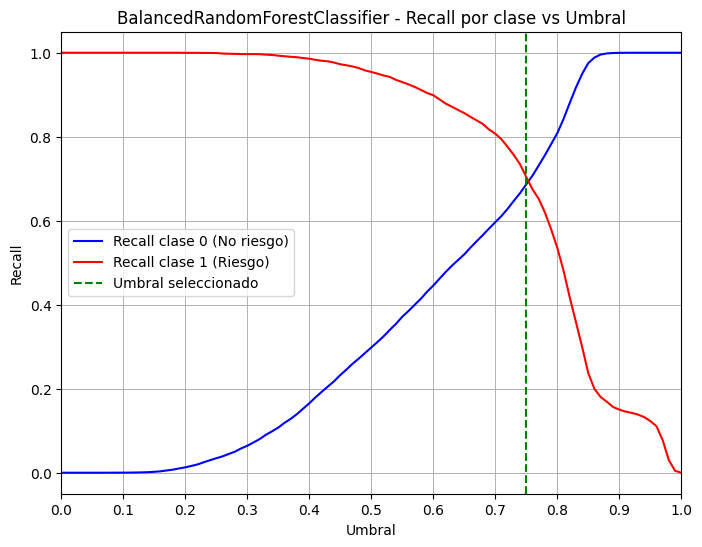

In [87]:
# Generar un modelo BalancedRandomForestClassifier
brf3 = BalancedRandomForestClassifier(
    n_estimators=35, # The number of trees in the forest
    max_depth=10, # The maximum depth of the tree, If None, then nodes are expanded until all leaves are pure
    min_samples_leaf=5, # The minimum number of samples required to be at a leaf node
    min_samples_split=12, # The minimum number of samples required to split an internal node
    bootstrap=True,    # cada árbol del bosque se entrena sobre una muestra aleatoria con reemplazo del dataset original
    class_weight=class_weights,
    oob_score=True,
    replacement=False,
    ccp_alpha=0.00001,
    n_jobs=-1,
    random_state=42
)
brf3.fit(X_train_seleccionado, y_train)

# Probabilidades
y_proba_brf = brf3.predict_proba(X_test_seleccionado)[:, 1]

# Umbrales
thresholds_brf = np.linspace(0.0, 1, 101)
recall_class_0_brf = []
recall_class_1_brf = []

for thr in thresholds_brf:
    y_pred_temp = (y_proba_brf >= thr).astype(int)
    recall_class_0_brf.append(recall_score(y_test, y_pred_temp, pos_label=0))
    recall_class_1_brf.append(recall_score(y_test, y_pred_temp, pos_label=1))

umbral = 0.75

# --- Gráfico ---
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(thresholds_brf, recall_class_0_brf, label="Recall clase 0 (No riesgo)", color="blue")
ax.plot(thresholds_brf, recall_class_1_brf, label="Recall clase 1 (Riesgo)", color="red")
ax.axvline(x=umbral, color="green", linestyle="--", label="Umbral seleccionado")

ax.set_xlabel("Umbral")
ax.set_ylabel("Recall")
ax.set_title("BalancedRandomForestClassifier - Recall por clase vs Umbral")
ax.legend()

# Forzar ticks y grilla cada 0.1
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.set_xlim(0, 1)

# Grilla alineada a los ticks
ax.grid(which='major', axis='x', linestyle='-', linewidth=0.7)
ax.grid(which='major', axis='y', linestyle='-', linewidth=0.7)

plt.show()

In [88]:
def evaluar_modelo(modelo, X_train, y_train, X_test, y_test, threshold):
    # ====== TRAIN ======
    y_proba_train = modelo.predict_proba(X_train)[:, 1]
    y_pred_train = (y_proba_train >= threshold).astype(int)

    print("\n--- MÉTRICAS TRAIN ---")
    print("ROC AUC:", roc_auc_score(y_train, y_proba_train))
    print("Balanced Accuracy:", balanced_accuracy_score(y_train, y_pred_train))
    print("F1 Score macro:", f1_score(y_train, y_pred_train, average='macro'))
    print(classification_report(y_train, y_pred_train))
    print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_train))

    # ====== TEST ======
    y_proba_test = modelo.predict_proba(X_test)[:, 1]
    y_pred_test = (y_proba_test >= threshold).astype(int)

    print("\n--- MÉTRICAS TEST ---")
    print("ROC AUC:", roc_auc_score(y_test, y_proba_test))
    print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_test))
    print("F1 Score macro:", f1_score(y_test, y_pred_test, average='macro'))
    print(classification_report(y_test, y_pred_test))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))

In [89]:
# BalancedRandomForestClassifier
evaluar_modelo(brf3, X_train_seleccionado, y_train, X_test_seleccionado, y_test, threshold=umbral)


--- MÉTRICAS TRAIN ---
ROC AUC: 0.8073386895723937
Balanced Accuracy: 0.7207859692012393
F1 Score macro: 0.6680509715520493
              precision    recall  f1-score   support

           0       0.89      0.69      0.78     45569
           1       0.44      0.75      0.56     14870

    accuracy                           0.71     60439
   macro avg       0.67      0.72      0.67     60439
weighted avg       0.78      0.71      0.72     60439

Confusion Matrix:
 [[31479 14090]
 [ 3706 11164]]

--- MÉTRICAS TEST ---
ROC AUC: 0.7754138097344531
Balanced Accuracy: 0.6953821014227778
F1 Score macro: 0.6493389142770238
              precision    recall  f1-score   support

           0       0.88      0.69      0.77     11392
           1       0.42      0.70      0.53      3718

    accuracy                           0.69     15110
   macro avg       0.65      0.70      0.65     15110
weighted avg       0.77      0.69      0.71     15110

Confusion Matrix:
 [[7822 3570]
 [1100 2618]]


In [79]:
# --- Tu scorer personalizado ---
def balanced_recall_score(y_true, y_pred):
    r0 = recall_score(y_true, y_pred, pos_label=0)
    r1 = recall_score(y_true, y_pred, pos_label=1)

    # Penalizar fuerte si alguno es menor a 0.6
    if r0 < 0.6 or r1 < 0.6:
        return -1  # valor muy bajo para que no lo elija
    # Si pasa el filtro, devuelve el promedio
    return (r0 + r1) / 2

# --- Búsqueda de hiperparámetros ---
param_grid = {
    'n_estimators': [30, 32, 35, 40],
    'max_depth': [10, 15, 20],
    'min_samples_leaf': [5, 10, 20],
    'min_samples_split': [8, 10, 12, 15],
    #'class_weight': class_weights,
}

best_score = -np.inf
best_params = None
early_stop_patience = 5
no_improve_count = 0

for params in ParameterGrid(param_grid):
    brf_temp = BalancedRandomForestClassifier(
        **params,
        random_state=42,
        n_jobs=-1
    )
    brf_temp.fit(X_train_seleccionado, y_train)

    y_pred_val = brf_temp.predict(X_test_seleccionado)
    score = balanced_recall_score(y_test, y_pred_val)

    if score > best_score:
        best_score = score
        best_params = params
        no_improve_count = 0
    else:
        no_improve_count += 1


print("✅ Mejor configuración:", best_params)
print("📈 Mejor balanced recall promedio:", best_score)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

✅ Mejor configuración: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 35}
📈 Mejor balanced recall promedio: 0.7048333513396716


## Guardar el modelo

In [80]:
"""carpeta = '/content/drive/MyDrive/proyecto_microcreditos/modelos'
os.makedirs(carpeta, exist_ok=True)
ruta_archivo = os.path.join(carpeta, 'modelo_bfr3.pkl')
dump(brf3, ruta_archivo)"""

['/content/drive/MyDrive/proyecto_microcreditos/modelos/modelo_bfr3.pkl']

### SHAP

In [81]:
"""# Crear explainer indicando que queremos explicaciones de probabilidades
explainer = shap.TreeExplainer(brf, model_output="raw")

# Calcular shap_values
shap_values = explainer.shap_values(X_test_seleccionado)

# Verificar si shap_values es lista (una entrada por clase)
print(type(shap_values))
if isinstance(shap_values, list):
    shap_riesgo = shap_values[1] # clase 1
else:
    shap_riesgo = shap_values

shap_riesgo = shap_riesgo[:, :, 1]  # shape: (19237, 28)

print(shap_riesgo.shape)"""

'# Crear explainer indicando que queremos explicaciones de probabilidades\nexplainer = shap.TreeExplainer(brf, model_output="raw")\n\n# Calcular shap_values\nshap_values = explainer.shap_values(X_test_seleccionado)\n\n# Verificar si shap_values es lista (una entrada por clase)\nprint(type(shap_values))\nif isinstance(shap_values, list):\n    shap_riesgo = shap_values[1] # clase 1\nelse:\n    shap_riesgo = shap_values\n\nshap_riesgo = shap_riesgo[:, :, 1]  # shape: (19237, 28)\n\nprint(shap_riesgo.shape)'

In [82]:
# DataFrame con nombres de features
X_test_df = pd.DataFrame(X_test_seleccionado, columns=[f'feat_{i}' for i in range(X_test_seleccionado.shape[1])])

# Explainer SHAP
explainer = shap.TreeExplainer(brf3, model_output="raw")
shap_values_full = explainer.shap_values(X_test_df)
shap_riesgo = shap_values_full[:, :, 1]  # clase 1

NameError: name 'brf' is not defined

In [ ]:
# Bar plot
shap.summary_plot(
    shap_riesgo,
    X_test_seleccionado,
    plot_type="bar",
    color_bar=True,
    show=True
)

In [ ]:
# Probabilidades y predicciones con umbral
umbral = 0.8
y_proba_brf = brf.predict_proba(X_test_seleccionado)[:, 1]
y_pred_umbral = (y_proba_brf >= umbral).astype(int)

# Crear explainer SHAP
explainer = shap.TreeExplainer(brf, model_output="raw")
shap_values_full = explainer.shap_values(X_test_seleccionado)

# Extraer shap_values de la clase 1
shap_riesgo = shap_values_full[:, :, 1]  # shape: (n_muestras, n_features)

# Convertir X_test a DataFrame
X_test_df = pd.DataFrame(X_test_seleccionado, columns=X_test_seleccionado.columns)

# Creamos colores según predicción de riesgo
colors = np.array(["green" if y==0 else "red" for y in y_pred_umbral])

# Graficar beeswarm con colores personalizados
shap.summary_plot(shap_riesgo, X_test_df, plot_type="dot", color=colors)

In [ ]:
# === 4. Dependence plot (ejemplo con la variable más importante) ===
# Encontrar la variable más importante
importances = abs(shap_riesgo).mean(0)
top_feature = X_test_seleccionado.columns[importances.argmax()]
shap.dependence_plot(top_feature, shap_riesgo, X_test_seleccionado)

In [ ]:
# === 5. Force plot (para un cliente específico) ===
# Ejemplo con el primer cliente
cliente_idx = 0
shap.force_plot(
    explainer.expected_value[1],
    shap_riesgo[cliente_idx, :],
    X_test_seleccionado.iloc[cliente_idx, :],
    matplotlib=True
)

In [ ]:
# === 6. Decision plot (para un cliente específico) ===
shap.decision_plot(
    explainer.expected_value[1],
    shap_riesgo[cliente_idx, :],
    X_test_seleccionado.iloc[cliente_idx, :]
)